In [11]:
from abc import ABC, abstractmethod
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as m

In [12]:
class Solution(ABC):
    @abstractmethod
    def load_file(self, file_path) -> None:
        pass

    @abstractmethod
    def solve(self, save_results=True, **kwargs) -> None:
        pass

    @abstractmethod
    def plot(self, **kwargs) -> None:
        pass

In [13]:
class Ex02(Solution):
    def __init__(self) -> None:
        self.r = None
        self.x_true = None
        self.t = None
        self.v = None
        self.l = None
        self.r_var = None
        self.v_var = None

        self.deltas = []
        self.errors = []
        self.sigmas = []
        self.ts = []

    def load_file(self, file_path) -> None:
        mat = sp.io.loadmat(file_path)
        self.r = mat["r"].reshape(-1)
        self.x_true = mat["x_true"].reshape(-1)
        self.t = mat["t"].reshape(-1)
        self.v = mat["v"].reshape(-1)
        self.l = mat["l"].reshape(-1)
        self.r_var = mat["r_var"].reshape(-1)
        self.v_var = mat["v_var"].reshape(-1)
        self.l = np.broadcast_to(self.l, self.r.shape)
        r_var = np.broadcast_to(self.r_var, self.r.shape)
        v_var = np.broadcast_to(self.v_var, self.r.shape)
        col_name = ["r", "x_true", "t", "v", "l", "r_var", "v_var"]
        df = pd.DataFrame(
            np.hstack(
                [
                    self.r.reshape(-1, 1),
                    self.x_true.reshape(-1, 1),
                    self.t.reshape(-1, 1),
                    self.v.reshape(-1, 1),
                    self.l.reshape(-1, 1),
                    r_var.reshape(-1, 1),
                    v_var.reshape(-1, 1),
                ]
            ),
            columns=col_name,
        )
        print(df.head())

    def solve(self, save_results=True, **kwargs) -> None:
        if self.r is None:
            raise ValueError("No data loaded")

        delta = kwargs["delta"]
        if delta == None:
            raise ValueError("No delta given")

        K = self.x_true.shape[0]
        T = 0.1
        k = (K - 1) // delta

        y_0 = self.l[0] - self.r[0]
        x_0 = y_0  # initial value
        u_0 = x_0

        # make z
        ## make u
        u = np.array(
            [T * self.v[i * delta : (i + 1) * delta].sum() for i in range(0, k)]
        )
        u = np.insert(u, 0, u_0).reshape(-1, 1)

        ## make y
        y = np.array([self.l[0] - self.r[(i + 1) * delta] for i in range(0, k)])
        y = np.insert(y, 0, y_0).reshape(-1, 1)

        ## make z
        z = np.vstack((u, y))

        # make H
        ## make A_inv
        A_inv = np.eye(k + 1)
        for row in range(1, A_inv.shape[0]):
            A_inv[row, row - 1] = -1

        ## make C
        C = np.eye(k + 1)

        ## make H
        H = np.vstack([A_inv, C])

        # make W
        ## make Q, R
        Q = np.eye(k + 1) * self.v_var[0]
        R = np.eye(k + 1) * self.r_var[0]

        ## make W
        W = np.block([[Q, np.zeros((k + 1, k + 1))], [np.zeros((k + 1, k + 1)), R]])
        W_inv = np.linalg.inv(W)

        # solution

        ### sparse way
        H_sparse = sp.sparse.csr_matrix(H)
        W_inv_sparse = sp.sparse.csr_matrix(W_inv)
        P_check_sparse = sp.sparse.linalg.inv(H_sparse.T * W_inv_sparse * H_sparse)
        x = P_check_sparse * H_sparse.T * W_inv_sparse * z

        x = x[1:].reshape(-1)
        x_true_sub = self.x_true[delta:K:delta]

        error = x_true_sub - x
        sigma = np.sqrt(P_check_sparse.diagonal()[1:])
        t = [(i + 1) * delta * T for i in range(0, k)]

        if save_results:
            self.deltas.append(delta)
            self.errors.append(error)
            self.sigmas.append(sigma)
            self.ts.append(t)

    def plot_5a(self) -> None:
        n_subplots = len(self.deltas)
        if n_subplots == 0:
            raise ValueError("No results to plot")

        n_col = 1 if n_subplots == 1 else 2
        n_row = 1 if n_subplots == 1 else m.ceil(n_subplots / n_col)

        fig, axs = plt.subplots(n_row, n_col, figsize=(8 * n_col, 5 * n_row))
        for i in range(n_subplots):
            delta = self.deltas[i]
            error = self.errors[i]
            sigma = self.sigmas[i]
            t = self.ts[i]

            row_pos = i // n_col
            col_pos = i % n_col

            if n_row == 1 and n_col == 1:
                ax = axs
            elif n_row == 1:
                ax = axs[col_pos]
            else:
                ax = axs[row_pos, col_pos]

            ax.set_title("δ = {} ".format(delta))
            ax.set_xlabel("time [s]")
            ax.set_ylabel("error [m]")
            ax.plot(t, error, linewidth=1, label="error")
            ax.plot(
                t, 3 * sigma, color="red", linewidth=0.5, linestyle="--", label="+3σ"
            )
            ax.plot(
                t, -3 * sigma, color="red", linewidth=0.5, linestyle="--", label="-3σ"
            )
            ax.fill_between(t, 3 * sigma, -3 * sigma, color="gray", alpha=0.1)
            ax.legend(loc="upper right")
            fig.suptitle("Task 5(a)", fontsize=18)
            fig.show()

    def plot_5b(self) -> None:
        n_subplots = len(self.deltas)
        if n_subplots == 0:
            raise ValueError("No results to plot")

        n_col = 1 if n_subplots == 1 else 2
        n_row = 1 if n_subplots == 1 else m.ceil(n_subplots / n_col)

        fig, axs = plt.subplots(n_row, n_col, figsize=(8 * n_col, 5 * n_row))
        for i in range(n_subplots):
            delta = self.deltas[i]
            error = self.errors[i]
            t = self.ts[i]

            row_pos = i // n_col
            col_pos = i % n_col

            if n_row == 1 and n_col == 1:
                ax = axs
            elif n_row == 1:
                ax = axs[col_pos]
            else:
                ax = axs[row_pos, col_pos]

            n_bins = 12
            ax.set_title("n_bins = {},  δ = {} ".format(n_bins, delta))
            ax.hist(error, bins=n_bins, density=True, alpha=0.8, label="error")
            ax.set_xlabel("error [m]")
            ax.set_ylabel("frequency")
            ax.legend(loc="upper right")
            fig.suptitle("Task 5(b)", fontsize=18)
            fig.show()

    def plot(self, **kwargs) -> None:
        if "task" not in kwargs:
            raise ValueError("No task given")
        if kwargs["task"] == "5a":
            self.plot_5a()
        elif kwargs["task"] == "5b":
            self.plot_5b()
        else:
            raise ValueError("Ex02 has no such plot task: ".format(kwargs["task"]))

In [14]:
class Factory:
    @staticmethod
    def create_solution(exercise: str) -> Solution:
        if exercise == "ex02":
            return Ex02()
        else:
            raise ValueError("No such exercise: {}".format(exercise))

          r    x_true    t    v         l     r_var     v_var
0  3.454506  0.984457  0.0  0.0  4.428479  0.000367  0.002261
1  3.456506  0.984434  0.1  0.0  4.428479  0.000367  0.002261
2  3.452506  0.984518  0.2  0.0  4.428479  0.000367  0.002261
3  3.454506  0.984452  0.3  0.0  4.428479  0.000367  0.002261
4  3.451506  0.984406  0.4  0.0  4.428479  0.000367  0.002261


/var/folders/tq/vp6by1g11w3d9p85nbjgnbyc0000gn/T/ipykernel_12413/2729709020.py:155: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/tq/vp6by1g11w3d9p85nbjgnbyc0000gn/T/ipykernel_12413/2729709020.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


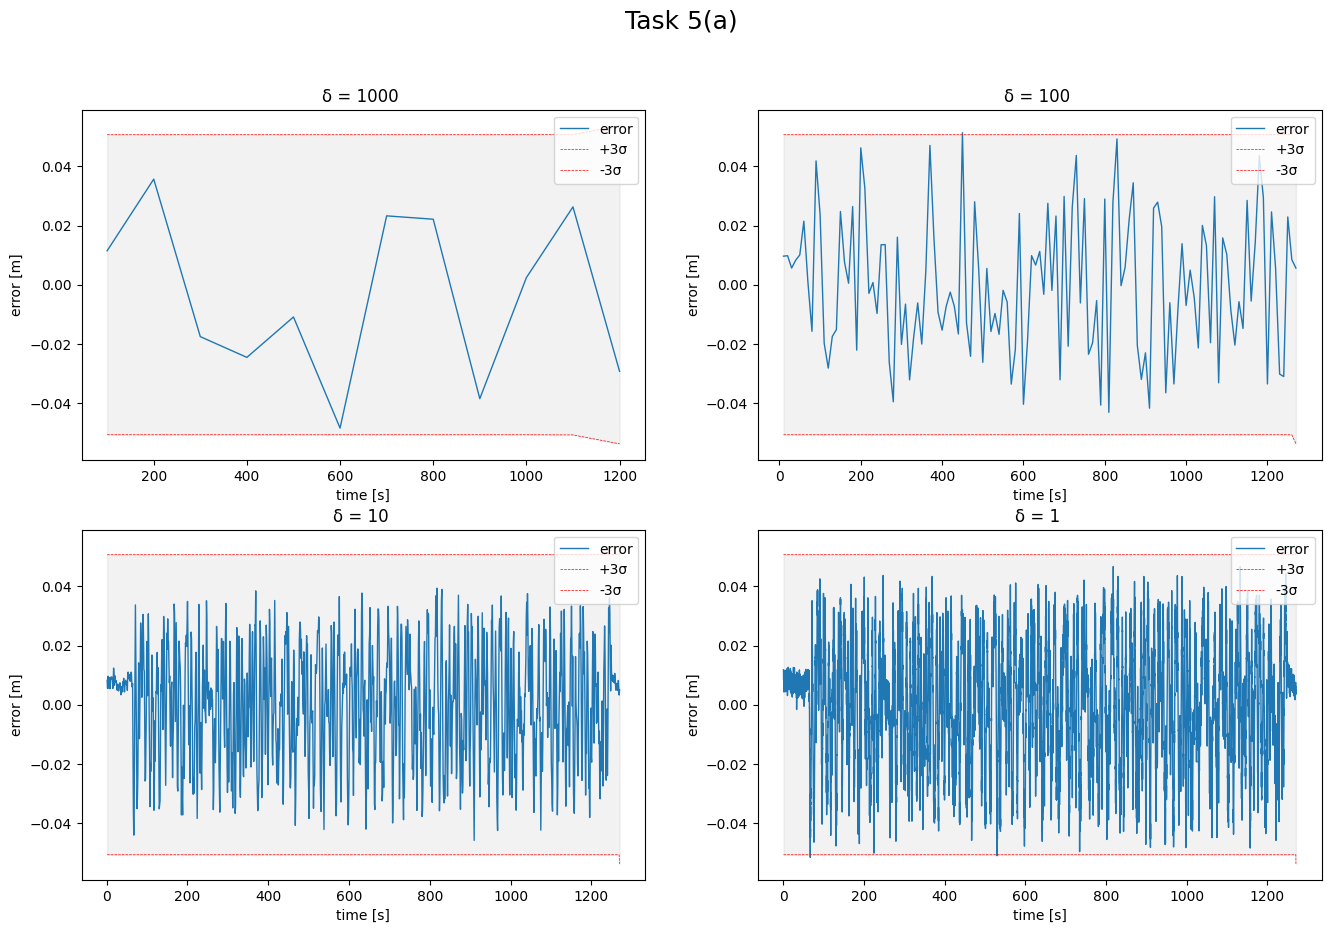

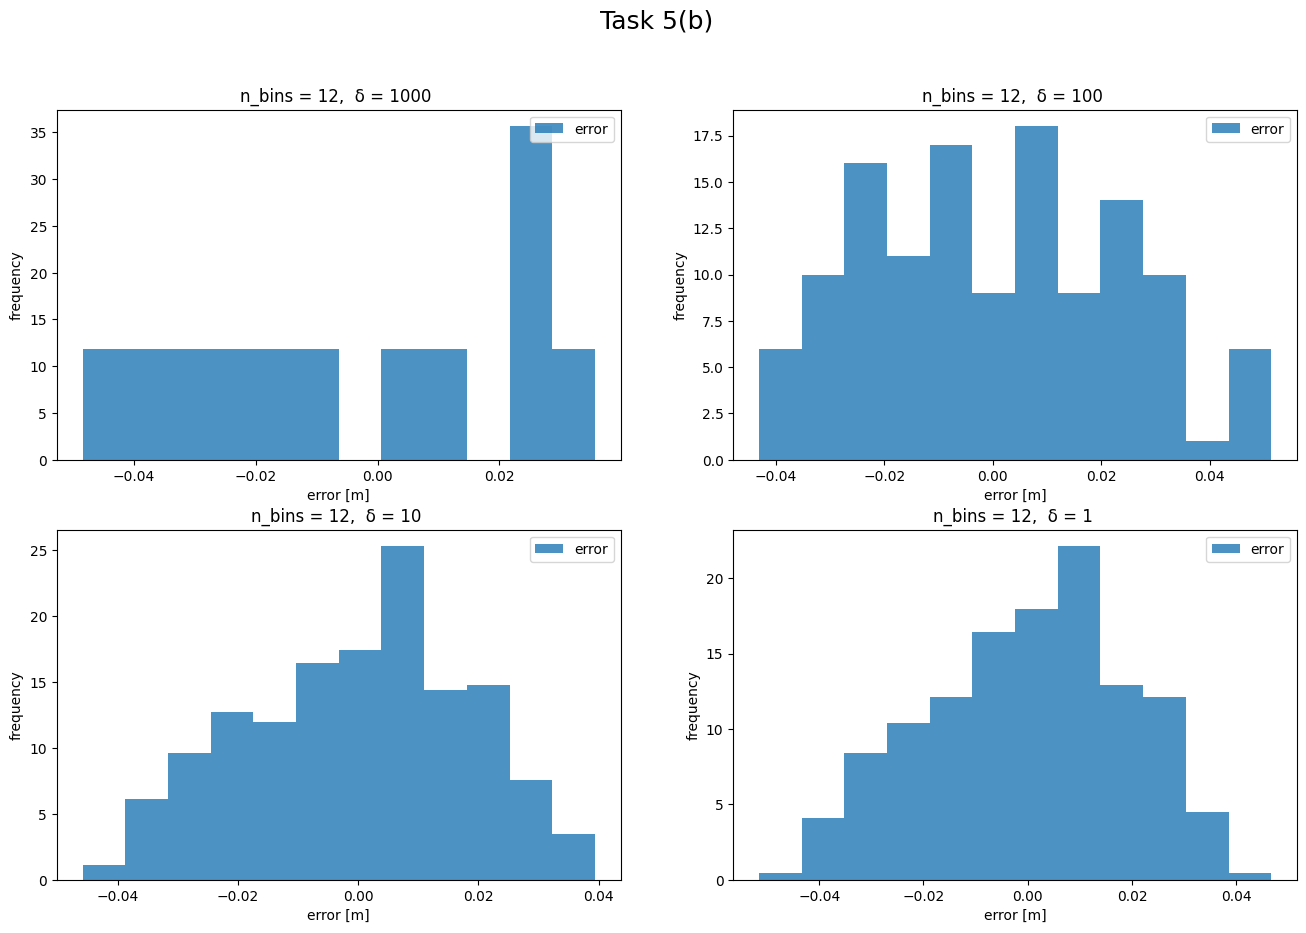

In [15]:
# test
f = Factory()
s = f.create_solution("ex02")

s.load_file("dataset1.mat")

s.solve(delta=1000)
s.solve(delta=100)
s.solve(delta=10)
s.solve(delta=1)

s.plot(task="5a")
s.plot(task="5b")